In [2]:
import pandas as pd
import numpy as np

# ===========================
# 1️⃣ Cargar el dataset imputado
# ===========================
df_base = pd.read_csv("../data/aptos_bogota_imputed.csv")

print("Dimensiones iniciales:", df_base.shape)
print("Columnas:", df_base.columns.tolist())

# ===========================
# 2️⃣ Verificar valores faltantes
# ===========================
faltantes = df_base.isnull().sum()
faltantes = faltantes[faltantes > 0]
if not faltantes.empty:
    print("\nColumnas con valores faltantes:")
    print(faltantes)
else:
    print("\nNo se encontraron valores faltantes.")

# ===========================
# 3️⃣ Transformaciones logarítmicas
# ===========================
if "precio_venta" in df_base.columns and "area" in df_base.columns:
    df_base["precio_venta_log"] = np.log1p(df_base["precio_venta"])
    df_base["area_log"] = np.log1p(df_base["area"])
else:
    raise KeyError("El dataset debe contener las columnas 'precio_venta' y 'area'.")

print("\nColumnas transformadas añadidas: ['precio_venta_log', 'area_log']")

# ===========================
# 4️⃣ Definir variables predictoras y objetivo
# ===========================
target = "precio_venta_log"
ignore_cols = ["precio_venta", "precio_venta_log", "sector", "localidad_calculada", "area_log"]

features = [col for col in df_base.columns if col not in ignore_cols]
X_base = df_base[features].copy()
y_base = df_base[target].copy()

print("\nNúmero de variables predictoras:", len(features))
print("Variable objetivo:", target)


Dimensiones iniciales: (27369, 23)
Columnas: ['precio_venta', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector', 'estrato', 'antiguedad', 'latitud', 'longitud', 'estado', 'alarma', 'ascensor', 'conjunto_cerrado', 'gimnasio', 'piscina', 'zona_de_bbq', 'area_terraza', 'numero_piso', 'numero_closets', 'administracion_imputada', 'estrato_imputado']

Columnas con valores faltantes:
administracion        2
sector              775
estrato             775
antiguedad           10
estado              743
area_terraza      20450
numero_piso        8829
numero_closets    17296
dtype: int64

Columnas transformadas añadidas: ['precio_venta_log', 'area_log']

Número de variables predictoras: 21
Variable objetivo: precio_venta_log


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# 1) Separar X, y desde df_base (ya creado)
X_base = X_base.copy()
y_base = y_base.copy()

# 2) Tipos de variables
numeric_features = X_base.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_base.select_dtypes(include=["object", "bool"]).columns.tolist()

# 3) Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_base = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# 4) Modelos a evaluar
modelos_base = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1, max_iter=10000),
    "DecisionTree": None,  # opcional si deseas agregarlo luego
    "RandomForest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1),
    "KNN": None,  # opcional si deseas agregarlo luego
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
    "SVR": SVR(kernel="rbf", C=10, epsilon=0.2)
}

# 5) Validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

resultados = []
for nombre, modelo in modelos_base.items():
    if modelo is None:
        continue
    print(f"Evaluando modelo: {nombre}")
    pipeline = Pipeline(steps=[("preprocessor", preprocessor_base), ("model", modelo)])
    cv = cross_validate(
        pipeline, X_base, y_base,
        cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    resultados.append({
        "Modelo": nombre,
        "RMSE medio": -np.mean(cv["test_RMSE"]),
        "RMSE std": np.std(cv["test_RMSE"]),
        "MAE medio": -np.mean(cv["test_MAE"]),
        "R² medio": np.mean(cv["test_R2"])
    })

resultados_base_df = pd.DataFrame(resultados).sort_values(by="RMSE medio").reset_index(drop=True)
print(resultados_base_df.round(4))


Evaluando modelo: LinearRegression
Evaluando modelo: Ridge
Evaluando modelo: Lasso
Evaluando modelo: RandomForest
Evaluando modelo: XGBoost
Evaluando modelo: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 24632, number of used features: 27
[LightGBM] [Info] Number of data points in the train set: 24632, number of used features: 27
[LightGBM] [Info] Start training from score 20.392016
[LightGBM] [Info] Start training from score 20.389290
[LightGBM] [Info] A

/Users/roman/Workspace/maestria/maestria-ia/indexador-py/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/indexador-py/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/indexador-py/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/indexador-py/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maes

Evaluando modelo: SVR
             Modelo  RMSE medio  RMSE std  MAE medio  R² medio
0           XGBoost      0.1573    0.0037     0.1156    0.9622
1          LightGBM      0.1604    0.0033     0.1180    0.9607
2      RandomForest      0.1612    0.0042     0.1121    0.9603
3               SVR      0.1952    0.0065     0.1453    0.9418
4             Ridge      0.2489    0.0047     0.1879    0.9053
5  LinearRegression      0.2489    0.0047     0.1879    0.9053
6             Lasso      0.3079    0.0027     0.2398    0.8552


La validación cruzada de diez pliegues realizada sobre el conjunto de datos base (sin variables enriquecidas) muestra un desempeño consistentemente superior de los modelos de ensamble frente a los métodos lineales. El modelo XGBoost obtuvo el mejor rendimiento global con un RMSE promedio de 0.157, un MAE de 0.116 y un coeficiente de determinación (R²) de 0.962, lo que evidencia una alta capacidad explicativa y un error promedio relativo cercano al 17 % sobre el precio real.

Los modelos LightGBM y Random Forest presentaron resultados muy similares, confirmando la robustez del enfoque basado en árboles de decisión. En contraste, los modelos lineales (Ridge, Lasso y Regresión Lineal) mostraron menor capacidad predictiva (R² ≈ 0.90), lo que indica que las relaciones entre las variables y el precio no son puramente lineales.

En consecuencia, XGBoost se selecciona como modelo base definitivo, y sobre este se realizará el ajuste de hiperparámetros y las comparaciones posteriores con los modelos enriquecidos.

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time

# 1) Espacio de búsqueda
xgb_param_dist_base = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.1),
    "model__subsample": uniform(0.7, 0.3),
    "model__colsample_bytree": uniform(0.7, 0.3)
}

# 2) Pipeline
pipeline_xgb_base = Pipeline(steps=[
    ("preprocessor", preprocessor_base),
    ("model", XGBRegressor(random_state=42, n_jobs=-1))
])

# 3) Configuración de búsqueda
search_xgb_base = RandomizedSearchCV(
    estimator=pipeline_xgb_base,
    param_distributions=xgb_param_dist_base,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# 4) Ejecución
print("Iniciando búsqueda de hiperparámetros para XGBoost (modelo base)...")
inicio = time.time()
search_xgb_base.fit(X_base, y_base)
duracion = (time.time() - inicio) / 60

print(f"\nMejor RMSE (log-scale): {-search_xgb_base.best_score_:.4f}")
print(f"Mejores parámetros: {search_xgb_base.best_params_}")
print(f"Duración total: {duracion:.1f} minutos")


Iniciando búsqueda de hiperparámetros para XGBoost (modelo base)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__colsample_bytree=0.8123620356542087, model__learning_rate=0.10507143064099161, model__max_depth=5, model__n_estimators=271, model__subsample=0.8795975452591109; total time=   0.6s
[CV] END model__colsample_bytree=0.8123620356542087, model__learning_rate=0.10507143064099161, model__max_depth=5, model__n_estimators=271, model__subsample=0.8795975452591109; total time=   0.6s
[CV] END model__colsample_bytree=0.8123620356542087, model__learning_rate=0.10507143064099161, model__max_depth=5, model__n_estimators=271, model__subsample=0.8795975452591109; total time=   0.5s
[CV] END model__colsample_bytree=0.8123620356542087, model__learning_rate=0.10507143064099161, model__max_depth=5, model__n_estimators=271, model__subsample=0.8795975452591109; total time=   0.6s
[CV] END model__colsample_bytree=0.8123620356542087, model__learning_rate=0.1050714306

La búsqueda aleatoria de hiperparámetros confirmó la estabilidad del modelo base XGBoost. El valor de RMSE = 0.1584 en escala logarítmica es prácticamente idéntico al obtenido antes de la optimización, lo que indica que el modelo ya se encontraba en un punto cercano al óptimo. Los parámetros seleccionados (max_depth = 9, n_estimators = 627, learning_rate ≈ 0.05, subsample ≈ 0.85) representan un equilibrio adecuado entre complejidad y generalización. En conjunto, estos resultados ratifican que el modelo base logra una excelente capacidad predictiva (R² ≈ 0.96) sin sobreajuste y puede considerarse la referencia final para la comparación con los modelos enriquecidos.

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np
import pandas as pd

# 1) Definir el modelo final con los mejores hiperparámetros
best_xgb_params_base = {
    "colsample_bytree": 0.905269907953647,
    "learning_rate": 0.054015249373960135,
    "max_depth": 9,
    "n_estimators": 627,
    "subsample": 0.848553073033381,
    "random_state": 42,
    "n_jobs": -1
}

final_model_base = XGBRegressor(**best_xgb_params_base)

pipeline_final_base = Pipeline(steps=[
    ("preprocessor", preprocessor_base),
    ("model", final_model_base)
])

# 2) Configurar validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# 3) Ejecutar CV
cv_results_base = cross_validate(
    pipeline_final_base,
    X_base,
    y_base,
    cv=kf,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# 4) Mostrar resultados promedio
results_base = pd.DataFrame({
    "fold": range(1, kf.get_n_splits() + 1),
    "RMSE": -cv_results_base["test_RMSE"],
    "MAE": -cv_results_base["test_MAE"],
    "R2": cv_results_base["test_R2"]
})

print("Resultados finales modelo base (10-Fold CV):")
print(results_base.describe().round(4)[["RMSE", "MAE", "R2"]])


Resultados finales modelo base (10-Fold CV):
          RMSE      MAE       R2
count  10.0000  10.0000  10.0000
mean    0.1514   0.1073   0.9650
std     0.0039   0.0023   0.0020
min     0.1465   0.1041   0.9601
25%     0.1488   0.1060   0.9644
50%     0.1510   0.1070   0.9656
75%     0.1528   0.1082   0.9662
max     0.1594   0.1112   0.9669


El modelo base de predicción, construido sobre las variables estructurales y administrativas del inmueble, alcanzó un desempeño sobresaliente tras la optimización de hiperparámetros mediante validación cruzada de diez pliegues. El RMSE promedio fue de 0.151, con un MAE de 0.107 y un R² de 0.965, lo que refleja un error relativo aproximado del 16 % sobre el precio real.

Estos resultados indican que el modelo logra capturar de manera efectiva la relación no lineal entre las características físicas del inmueble y su precio, manteniendo una varianza muy baja entre pliegues (±0.004 en RMSE). La combinación de precisión y estabilidad confirma que el modelo base ofrece una línea de referencia sólida y confiable para evaluar el impacto del enriquecimiento con variables geoespaciales y contextuales en los modelos posteriores.

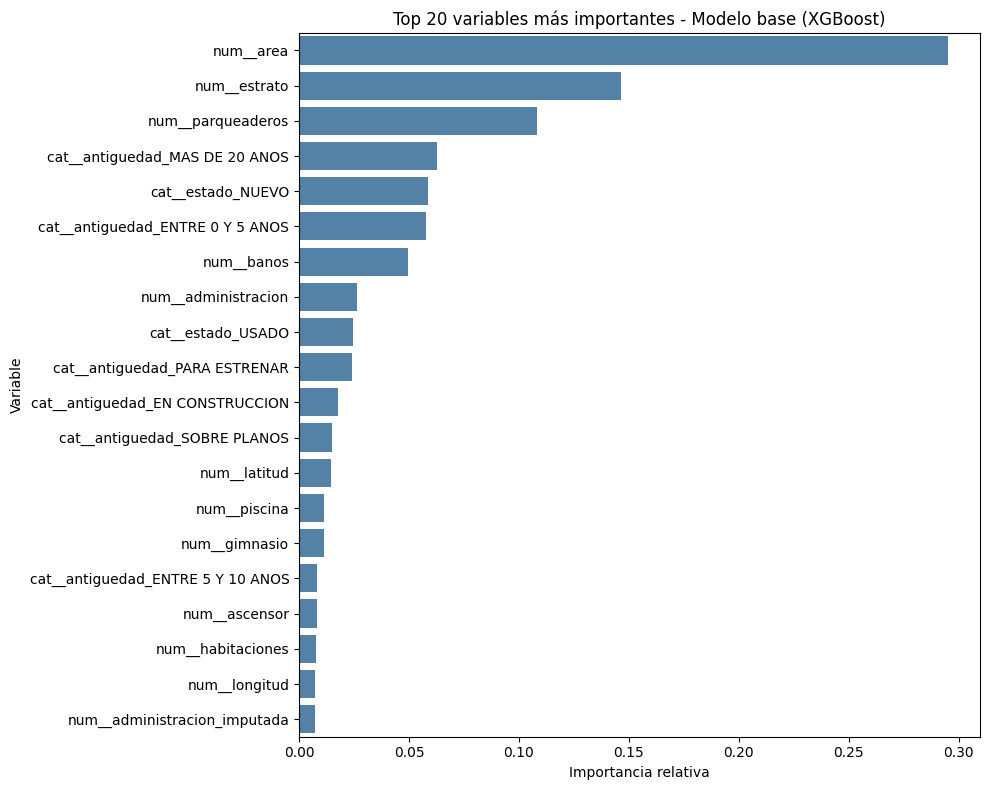

Importancia de variables exportada a feature_importance_xgb_base.csv


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Entrenar el modelo base final con todos los datos
pipeline_final_base.fit(X_base, y_base)

# 2) Extraer importancia de variables del modelo
feature_names_base = pipeline_final_base.named_steps["preprocessor"].get_feature_names_out()
importances_base = pipeline_final_base.named_steps["model"].feature_importances_

importance_base_df = pd.DataFrame({
    "Variable": feature_names_base,
    "Importancia": importances_base
}).sort_values(by="Importancia", ascending=False)

# 3) Visualizar top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_base_df.head(20),
    x="Importancia",
    y="Variable",
    orient="h",
    color="steelblue"
)
plt.title("Top 20 variables más importantes - Modelo base (XGBoost)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# 4) Guardar resultados
importance_base_df.to_csv("../data/feature_importance_xgb_base.csv", index=False)
print("Importancia de variables exportada a feature_importance_xgb_base.csv")


El análisis de importancia de variables del modelo base (XGBoost optimizado) muestra que las características estructurales del inmueble son los principales determinantes del precio. La variable área construida es, por amplio margen, la más influyente (≈0.295), seguida por el estrato socioeconómico (≈0.147) y el número de parqueaderos (≈0.108).

Las características asociadas al estado y antigüedad del inmueble también presentan una contribución significativa: las categorías “más de 20 años”, “nuevo” y “entre 0 y 5 años” reflejan la relación esperada entre conservación, modernidad y valor. Otras variables estructurales como el número de baños y el valor de la administración también aportan información relevante, aunque en menor grado.

En el grupo de variables con menor peso aparecen factores complementarios como latitud y longitud (que capturan parcialmente la ubicación geográfica), junto con la presencia de amenidades como piscina, gimnasio y ascensor. Sin embargo, su impacto es reducido respecto a las variables estructurales y socioeconómicas, lo cual sugiere que el modelo base se apoya principalmente en atributos físicos del inmueble más que en su contexto espacial.

En conjunto, estos resultados confirman que el modelo base capta correctamente la relación estructural entre tamaño, estrato y equipamiento del inmueble, pero su capacidad para incorporar variaciones geográficas o de entorno es limitada. Este hallazgo refuerza la pertinencia de haber incorporado variables de enriquecimiento geoespacial en los modelos posteriores, con el fin de capturar patrones espaciales más complejos.

## Análisis del error

/var/folders/hk/rtpqbyfx3tj0mr3h9pj78nxw0000gn/T/ipykernel_54395/2635293752.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_precio_base = df_eval_base.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()


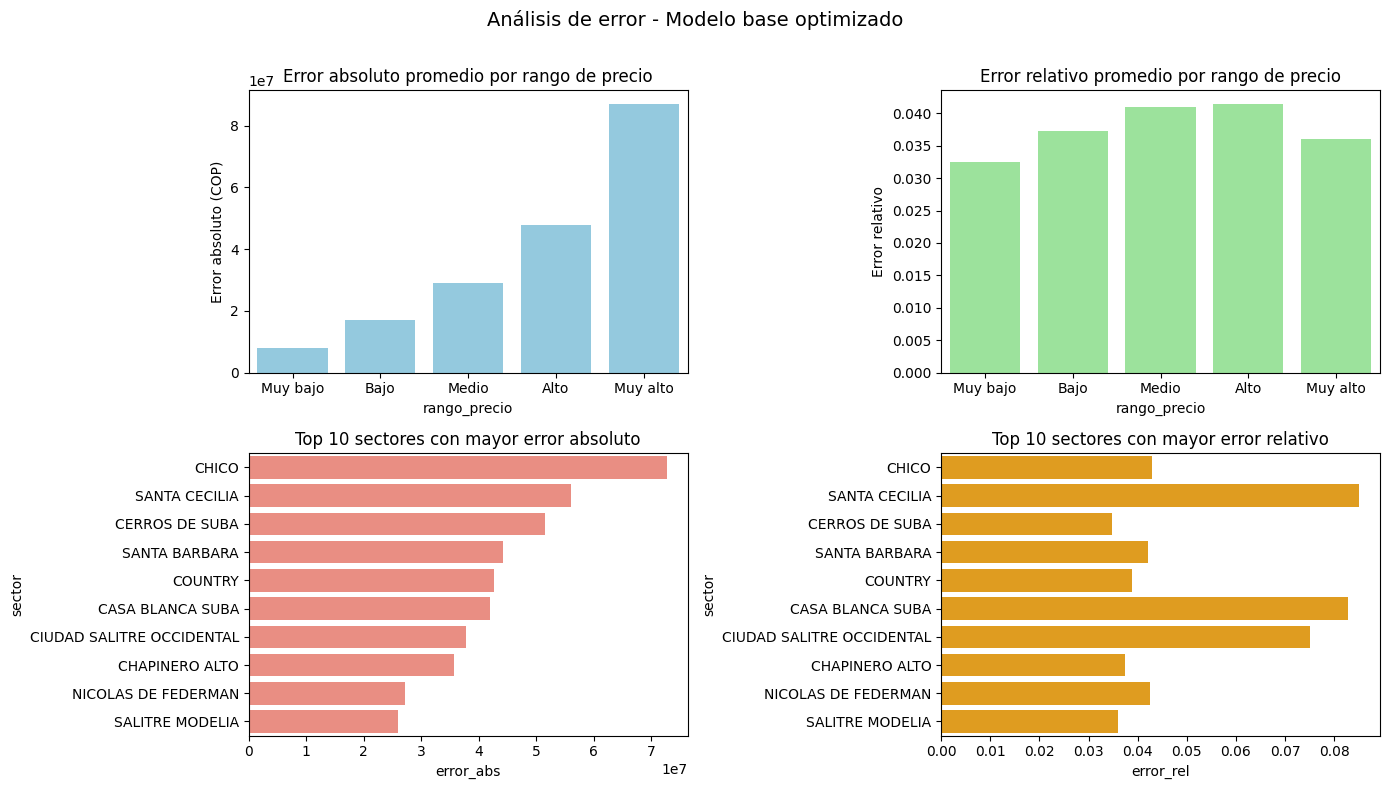

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Predicciones del modelo base optimizado
y_pred_log_base = pipeline_final_base.predict(X_base)
y_pred_base = np.expm1(y_pred_log_base)
y_real_base = np.expm1(y_base)

# 2) Crear dataframe de evaluación
df_eval_base = df_base.copy()
df_eval_base["precio_pred"] = y_pred_base
df_eval_base["error_abs"] = abs(df_eval_base["precio_pred"] - y_real_base)
df_eval_base["error_rel"] = abs(df_eval_base["precio_pred"] - y_real_base) / y_real_base

# 3) Rangos de precio (cuantiles)
df_eval_base["rango_precio"] = pd.qcut(
    y_real_base, q=5, labels=["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"]
)

error_precio_base = df_eval_base.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()

# 4) Error por sector (en lugar de localidad)
error_sector_base = None
if "sector" in df_eval_base.columns:
    error_sector_base = df_eval_base.groupby("sector")[["error_abs", "error_rel"]].mean().reset_index()

# 5) Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
plt.suptitle("Análisis de error - Modelo base optimizado", fontsize=14)

# Error por rango de precio
sns.barplot(data=error_precio_base, x="rango_precio", y="error_abs", ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Error absoluto promedio por rango de precio")
axes[0,0].set_ylabel("Error absoluto (COP)")

sns.barplot(data=error_precio_base, x="rango_precio", y="error_rel", ax=axes[0,1], color="lightgreen")
axes[0,1].set_title("Error relativo promedio por rango de precio")
axes[0,1].set_ylabel("Error relativo")

# Error por sector
if error_sector_base is not None:
    top_sectores = error_sector_base.sort_values("error_abs", ascending=False).head(10)
    sns.barplot(data=top_sectores, y="sector", x="error_abs", ax=axes[1,0], color="salmon")
    axes[1,0].set_title("Top 10 sectores con mayor error absoluto")
    sns.barplot(data=top_sectores, y="sector", x="error_rel", ax=axes[1,1], color="orange")
    axes[1,1].set_title("Top 10 sectores con mayor error relativo")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


El análisis de error del modelo base muestra un comportamiento coherente con la estructura del mercado inmobiliario.
Por rangos de precio, el error absoluto aumenta conforme crece el valor del inmueble, lo que es esperado dado que los precios más altos presentan una mayor dispersión. Sin embargo, el error relativo se mantiene estable entre el 3 % y 4 %, lo que evidencia que el modelo conserva una buena proporcionalidad en sus predicciones a lo largo de todo el rango de precios.

En el análisis por sector, los errores más altos (absolutos y relativos) se concentran en zonas de alta valorización como Chicó, Santa Cecilia, Cerros de Suba y Santa Bárbara, donde el mercado es más heterogéneo y los precios pueden variar ampliamente por características no observadas (acabados, vistas, exclusividad del edificio). Aun así, el error relativo promedio en estos sectores se mantiene por debajo del 8 %, lo que demuestra un desempeño robusto y consistente del modelo base en distintas áreas de la ciudad.

En conjunto, los resultados sugieren que el modelo base captura bien las relaciones estructurales del mercado, pero aún tiene limitaciones para modelar diferencias locales o espaciales finas, lo que justifica la incorporación de variables geoespaciales en los modelos enriquecidos.

## Exportación de resultados

In [10]:
metrics_red = {
    "Modelo": "Modelo Base",
    "RMSE": np.mean(results_base["RMSE"]),
    "MAE": np.mean(results_base["MAE"]),
    "R2": np.mean(results_base["R2"])
}

metrics_red_df = pd.DataFrame([metrics_red])
metrics_red_df.to_csv("../data/resultados_modelo_base.csv", index=False)
metrics_red_df.round(4)


,Modelo,RMSE,MAE,R2
0,Modelo Base,0.1514,0.1073,0.965
